In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout, GlobalMaxPool1D, BatchNormalization, Bidirectional
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_ml.csv to train_ml (1).csv


In [ ]:
df = pd.read_csv('train_ml.csv')

In [ ]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
df.shape

(7613, 5)

In [ ]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
def clean_tweet(tweet:str) -> str:
    """
    Convert all text to lowercase, remove stock market tickers, RT symbol, hyperlinks and the hastag symbol
    :param tweet: tweet by a unique user
    :return: cleaned string without hashtags, emojis, and punctuation
    """
    # make text lower case
    tweet = tweet.lower()
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', str(tweet))
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', str(tweet))
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', str(tweet))
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', str(tweet))
    
    # remove punctuation
    punct = set(string.punctuation)
    tweet = "".join(ch for ch in tweet if ch not in punct)
    
    # remove stopwords
    stop_words = set(stopwords.words("english"))
    tweet = " ".join(word for word in tweet.split() if word not in stop_words)
    
    return tweet

In [ ]:
df["text"] = df["text"].apply(clean_tweet)

In [ ]:
df['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [ ]:
# Loading test dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_ml.csv to test_ml (1).csv


In [ ]:
df_test = pd.read_csv('test_ml.csv')

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test["text"] = df_test["text"].apply(clean_tweet)

In [ ]:
df_test['text']

0                             happened terrible car crash
1       heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                  typhoon soudelor kills 28 china taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety faste...
3259    storm ri worse last hurricane cityamp3others h...
3260                        green line derailment chicago
3261             meg issues hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [ ]:
# Using google colab text cleaning
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and lemma
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df["text"] = df["text"].apply(clean_text)

In [ ]:
df['text']

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    aria ahrary thetawniest control wild fire cali...
7610             utc km volcano hawaii http co zdtoyd ebj
7611    police investigating bike collided car little ...
7612    latest home razed northern california wildfire...
Name: text, Length: 7613, dtype: object

In [ ]:
df_test['text'] = df_test['text'].apply(clean_text)

In [ ]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety fasten...
3259,10865,NaN,NaN,storm ri worse last hurricane city amp others ...
3260,10868,NaN,NaN,green line derailment chicago http co utbxlcbiuy
3261,10874,NaN,NaN,meg issue hazardous weather outlook hwo http c...


In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
df['text']=df['text'].apply(lambda x : remove_emoji(x))

In [ ]:
# remove URL
def remove_url(string):
  url = re.compile(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''')
  return url.sub(r'', string)


In [ ]:
df['text']=df['text'].apply(lambda x : remove_url(x))

In [ ]:
# Remove html tags
def remove_html(string):
    html=re.compile(r'<.*?>')
    return html.sub(r'',string)

In [ ]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [ ]:
def remove_punct(string):
  punc = re.compile(r'[^\w\s]')
  return punc.sub(r'', string)

In [ ]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [ ]:
df['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    aria_ahrary TheTawniest The out of control wil...
7610                M194 0104 UTC5km S of Volcano Hawaii 
7611    Police investigating after an ebike collided w...
7612    The Latest More Homes Razed by Northern Califo...
Name: text, Length: 7613, dtype: object

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-05-02 20:35:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-02 20:35:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-02 20:35:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip


--2021-05-04 19:23:36--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-05-04 19:23:36--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-05-04 19:23:36--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip glove*.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 1193514 word vectors.


In [ ]:
embeddings_index

{'<user>': array([ 0.63006  ,  0.65177  ,  0.25545  ,  0.018593 ,  0.043094 ,
         0.047194 ,  0.23218  ,  0.11613  ,  0.17371  ,  0.40487  ,
         0.022524 , -0.076731 , -2.2911   ,  0.094127 ,  0.43293  ,
         0.041801 ,  0.063175 , -0.64486  , -0.43657  ,  0.024114 ,
        -0.082989 ,  0.21686  , -0.13462  , -0.22336  ,  0.39436  ,
        -2.1724   , -0.39544  ,  0.16536  ,  0.39438  , -0.35182  ,
        -0.14996  ,  0.10502  , -0.45937  ,  0.27729  ,  0.8924   ,
        -0.042313 , -0.009345 ,  0.55017  ,  0.095521 ,  0.070504 ,
        -1.1781   ,  0.013723 ,  0.17742  ,  0.74142  ,  0.17716  ,
         0.038468 , -0.31684  ,  0.08941  ,  0.20557  , -0.34328  ,
        -0.64303  , -0.878    , -0.16293  , -0.055925 ,  0.33898  ,
         0.60664  , -0.2774   ,  0.33626  ,  0.21603  , -0.11051  ,
         0.0058673, -0.64757  , -0.068222 , -0.77414  ,  0.13911  ,
        -0.15851  , -0.61885  , -0.10192  , -0.47     ,  0.19787  ,
         0.42175  , -0.18458  ,  0.080

In [ ]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))] # isalpha() method returns True if all the characters are alphabet letters (a-z)
        corpus.append(words)
    return corpus

In [ ]:
corpus=create_corpus(df)


100%|██████████| 7613/7613 [00:00<00:00, 8163.26it/s]


In [ ]:
corpus_test = create_corpus(df_test)

100%|██████████| 3263/3263 [00:00<00:00, 7842.56it/s]


In [ ]:
corpus[1]

['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']

In [ ]:
corpus_test[1]

['heard', 'earthquake', 'different', 'city', 'stay', 'safe', 'everyone']

In [ ]:
# For train data
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)


In [ ]:
# For test data
MAX_LEN=50
tokenizer_obj_test=Tokenizer()
tokenizer_obj_test.fit_on_texts(corpus_test)
sequences_test=tokenizer_obj.texts_to_sequences(corpus_test)

In [ ]:
# For train data
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
# For test data
tweet_pad_test =pad_sequences(sequences_test,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
tweet_pad.shape

(7613, 50)

In [ ]:
tweet_pad_test.shape

(3263, 50)

In [ ]:
len(tokenizer_obj.word_index)

14895

In [ ]:
tokenizer_obj.word_index.items()

dict_items([('fire', 1), ('like', 2), ('im', 3), ('amp', 4), ('get', 5), ('new', 6), ('one', 7), ('people', 8), ('dont', 9), ('time', 10), ('news', 11), ('u', 12), ('video', 13), ('disaster', 14), ('emergency', 15), ('year', 16), ('body', 17), ('day', 18), ('police', 19), ('building', 20), ('home', 21), ('would', 22), ('go', 23), ('still', 24), ('say', 25), ('family', 26), ('got', 27), ('storm', 28), ('life', 29), ('california', 30), ('look', 31), ('bomb', 32), ('back', 33), ('burning', 34), ('know', 35), ('crash', 36), ('suicide', 37), ('train', 38), ('world', 39), ('flood', 40), ('man', 41), ('car', 42), ('death', 43), ('see', 44), ('first', 45), ('pm', 46), ('love', 47), ('attack', 48), ('cant', 49), ('going', 50), ('today', 51), ('make', 52), ('let', 53), ('two', 54), ('war', 55), ('nuclear', 56), ('rt', 57), ('dead', 58), ('want', 59), ('need', 60), ('woman', 61), ('accident', 62), ('full', 63), ('good', 64), ('think', 65), ('may', 66), ('killed', 67), ('hiroshima', 68), ('take', 

In [ ]:
num_words=len(tokenizer_obj.word_index)+1
embedding_matrix=np.zeros((num_words,100)) # it is 100d
for word,i in tqdm(tokenizer_obj.word_index.items()):
    if i > num_words:
        continue
    emb_vec=embeddings_index.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 14895/14895 [00:00<00:00, 316035.22it/s]


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.21063   , -0.010992  , -0.17552   , ..., -0.37547001,
         0.58029002,  0.16067   ],
       [-0.67391002,  0.54449999, -0.44868001, ...,  0.49522001,
         1.27960002, -0.75579   ],
       ...,
       [ 0.20125   , -0.091671  ,  0.51243001, ..., -0.19316   ,
         0.33122   ,  0.25007999],
       [ 0.70836997, -0.42631999,  0.067026  , ...,  0.21108   ,
         0.068173  , -0.68549001],
       [-0.054511  , -0.34237999, -0.67264003, ...,  0.47459999,
         0.31121001,  0.60255003]])

In [ ]:
embedding_matrix.shape

(14896, 100)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(tweet_pad,df['target'].values,test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6090, 50)
(1523, 50)
(6090,)
(1523,)


In [ ]:
# Model using twitter pretrained model
model=Sequential()

embedding=Embedding(num_words,100,weights=[embedding_matrix],
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(Bidirectional(LSTM(units=64, dropout=0.1,  recurrent_dropout=0.1)))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
import tensorflow as tf

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('large_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

In [ ]:
history=model.fit(X_train,y_train,batch_size=20,epochs=6,validation_data=(X_test,y_test),verbose=1, callbacks = [checkpoint])

Epoch 1/6
305/305 [==============================] - 46s 131ms/step - loss: 0.5411 - accuracy: 0.7294 - val_loss: 0.4498 - val_accuracy: 0.7958
Epoch 2/6
305/305 [==============================] - 41s 134ms/step - loss: 0.4315 - accuracy: 0.8181 - val_loss: 0.4579 - val_accuracy: 0.7932
Epoch 3/6
305/305 [==============================] - 40s 131ms/step - loss: 0.4093 - accuracy: 0.8200 - val_loss: 0.4378 - val_accuracy: 0.8102
Epoch 4/6
305/305 [==============================] - 41s 133ms/step - loss: 0.3787 - accuracy: 0.8422 - val_loss: 0.4574 - val_accuracy: 0.8004
Epoch 5/6
305/305 [==============================] - 41s 134ms/step - loss: 0.3497 - accuracy: 0.8531 - val_loss: 0.4876 - val_accuracy: 0.8024
Epoch 6/6
305/305 [==============================] - 40s 132ms/step - loss: 0.3183 - accuracy: 0.8653 - val_loss: 0.4830 - val_accuracy: 0.7971


In [ ]:
# Making predictions
model.load_weights('large_model.h5')



In [ ]:
pred = model.predict(tweet_pad_test, verbose=-1)

In [ ]:
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [ ]:
pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
df_sub = pd.DataFrame(pred)

In [ ]:
df_sub.columns = ['label']


In [ ]:
df_sub['label'].value_counts()

0.0    2069
1.0    1194
Name: label, dtype: int64

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')


In [ ]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
sample_submission["target"] = pred.astype('int64')
sample_submission.to_csv("submission.csv", index=False)

In [ ]:
# Confusion matrix plot
from sklearn.metrics import confusion_matrix

In [ ]:
val_pred = model.predict(X_test, verbose=-1)
val_pred[val_pred > 0.5] = 1
val_pred[val_pred <= 0.5] = 0

In [ ]:
df_val_pred = pd.DataFrame(val_pred)
df_val_pred.columns = ['label']
df_val_pred['label'].value_counts()

0.0    980
1.0    543
Name: label, dtype: int64

In [ ]:
confusion_matrix( y_test, val_pred)  

array([[784,  93],
       [196, 450]])

In [ ]:
import itertools 

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['Not Real','Real']

In [ ]:
cm = confusion_matrix( y_test, val_pred)  

Confusion matrix, without normalization
[[784  93]
 [196 450]]


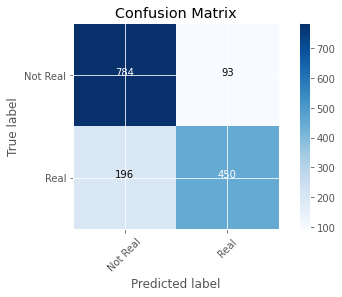

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
print(classification_report(y_test, val_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       877
           1       0.83      0.70      0.76       646

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


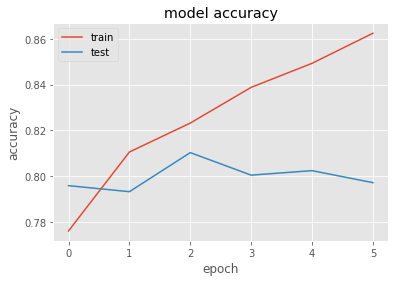

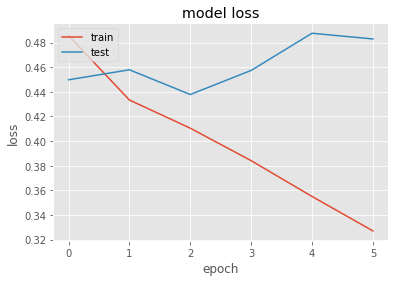

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# one layer Bidriectional LSTM for glove twitter 
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(Bidirectional(LSTM(units=32)))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,y_train,batch_size=15,epochs=5
                  ,validation_data=(X_test,y_test),verbose=1)

Epoch 1/5
406/406 [==============================] - 14s 27ms/step - loss: 0.5609 - accuracy: 0.7090 - val_loss: 0.4517 - val_accuracy: 0.8024
Epoch 2/5
406/406 [==============================] - 10s 25ms/step - loss: 0.4328 - accuracy: 0.8133 - val_loss: 0.4473 - val_accuracy: 0.8056
Epoch 3/5
406/406 [==============================] - 10s 24ms/step - loss: 0.4118 - accuracy: 0.8238 - val_loss: 0.4427 - val_accuracy: 0.7978
Epoch 4/5
406/406 [==============================] - 10s 24ms/step - loss: 0.3908 - accuracy: 0.8380 - val_loss: 0.4674 - val_accuracy: 0.7997
Epoch 5/5
406/406 [==============================] - 10s 24ms/step - loss: 0.3664 - accuracy: 0.8388 - val_loss: 0.4569 - val_accuracy: 0.8083


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


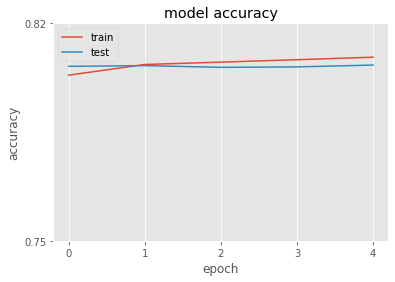

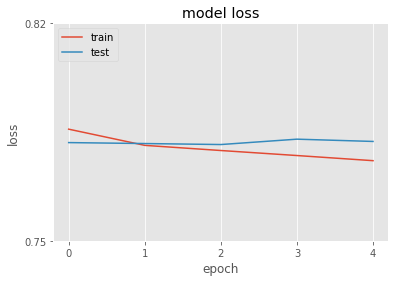

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylim(['0.75','0.82'])
plt.xticks(np.arange(0, 5, 1.0))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim(['0.75','0.82'])
plt.xticks(np.arange(0, 5, 1.0))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history=model.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_test,y_test),verbose=2)

Epoch 1/10
96/96 - 40s - loss: 0.5254 - accuracy: 0.7522 - val_loss: 0.4638 - val_accuracy: 0.7932
Epoch 2/10
96/96 - 28s - loss: 0.4642 - accuracy: 0.7941 - val_loss: 0.4516 - val_accuracy: 0.8004
Epoch 3/10
96/96 - 28s - loss: 0.4485 - accuracy: 0.7977 - val_loss: 0.4442 - val_accuracy: 0.7978
Epoch 4/10
96/96 - 28s - loss: 0.4301 - accuracy: 0.8080 - val_loss: 0.4429 - val_accuracy: 0.8024
Epoch 5/10
96/96 - 28s - loss: 0.4213 - accuracy: 0.8144 - val_loss: 0.4443 - val_accuracy: 0.8076
Epoch 6/10
96/96 - 29s - loss: 0.4082 - accuracy: 0.8227 - val_loss: 0.4430 - val_accuracy: 0.8017
Epoch 7/10
96/96 - 29s - loss: 0.3957 - accuracy: 0.8292 - val_loss: 0.4414 - val_accuracy: 0.7991
Epoch 8/10
96/96 - 29s - loss: 0.3800 - accuracy: 0.8360 - val_loss: 0.4490 - val_accuracy: 0.8043
Epoch 9/10
96/96 - 29s - loss: 0.3711 - accuracy: 0.8383 - val_loss: 0.4627 - val_accuracy: 0.8076
Epoch 10/10
96/96 - 29s - loss: 0.3593 - accuracy: 0.8417 - val_loss: 0.4504 - val_accuracy: 0.8096


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


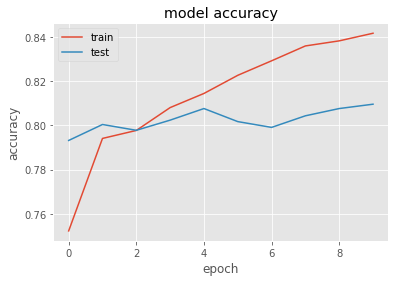

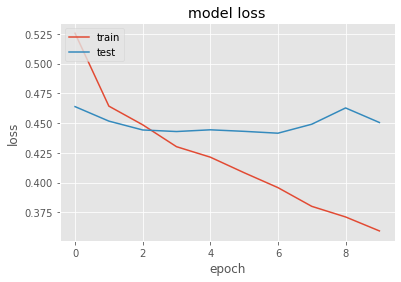

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#making predictions

pred_bi = model.predict(tweet_pad_test, verbose=-1)

In [ ]:
pred_bi[pred_bi > 0.5] = 1
pred_bi[pred_bi <= 0.5] = 0

In [ ]:
df_sub = pd.DataFrame(pred_bi)
df_sub.columns = ['label']

In [ ]:
df_sub['label'].value_counts()

0.0    2056
1.0    1207
Name: label, dtype: int64

In [ ]:
sample_submission["target"] = pred_bi.astype('int64')
sample_submission.to_csv("submission_bi.csv", index=False)

In [ ]:
#Using glove wiki data


In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,weights=[embedding_matrix],
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='categorical',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1612600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,654,905
Trainable params: 42,305
Non-trainable params: 1,612,600
_________________________________________________________________


In [ ]:
df['target'].shape

(7613,)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(tweet_pad,df['target'].values,test_size=0.2)


In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1523/1523 - 75s - loss: 0.6893 - accuracy: 0.5675 - val_loss: 0.6661 - val_accuracy: 0.5785
Epoch 2/15
1523/1523 - 72s - loss: 0.5915 - accuracy: 0.7038 - val_loss: 0.5184 - val_accuracy: 0.7814
Epoch 3/15
1523/1523 - 72s - loss: 0.5444 - accuracy: 0.7502 - val_loss: 0.4937 - val_accuracy: 0.7879
Epoch 4/15
1523/1523 - 72s - loss: 0.5306 - accuracy: 0.7534 - val_loss: 0.4777 - val_accuracy: 0.7965
Epoch 5/15
1523/1523 - 71s - loss: 0.5185 - accuracy: 0.7575 - val_loss: 0.4668 - val_accuracy: 0.8030
Epoch 6/15
1523/1523 - 72s - loss: 0.5080 - accuracy: 0.7696 - val_loss: 0.4613 - val_accuracy: 0.8030
Epoch 7/15
1523/1523 - 72s - loss: 0.5027 - accuracy: 0.7739 - val_loss: 0.4569 - val_accuracy: 0.8024
Epoch 8/15
1523/1523 - 72s - loss: 0.5002 - accuracy: 0.7724 - val_loss: 0.4521 - val_accuracy: 0.8096
Epoch 9/15
1523/1523 - 72s - loss: 0.4929 - accuracy: 0.7759 - val_loss: 0.4486 - val_accuracy: 0.8096
Epoch 10/15
1523/1523 - 72s - loss: 0.4951 - accuracy: 0.7768 - val_loss:

In [ ]:
from keras.layers import Bidirectional

model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(units=64, dropout=0.1,  recurrent_dropout=0.1, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,y_train,batch_size=15,epochs=10,validation_data=(X_test,y_test),verbose=1)

Epoch 1/10
406/406 [==============================] - 68s 152ms/step - loss: 0.6643 - accuracy: 0.6389 - val_loss: 0.5827 - val_accuracy: 0.7708
Epoch 2/10
406/406 [==============================] - 60s 149ms/step - loss: 0.5604 - accuracy: 0.7704 - val_loss: 0.5089 - val_accuracy: 0.7682
Epoch 3/10
406/406 [==============================] - 61s 149ms/step - loss: 0.5003 - accuracy: 0.7790 - val_loss: 0.4970 - val_accuracy: 0.7774
Epoch 4/10
406/406 [==============================] - 60s 149ms/step - loss: 0.4953 - accuracy: 0.7732 - val_loss: 0.4887 - val_accuracy: 0.7919
Epoch 5/10
406/406 [==============================] - 60s 148ms/step - loss: 0.4729 - accuracy: 0.7849 - val_loss: 0.4844 - val_accuracy: 0.7945
Epoch 6/10
406/406 [==============================] - 60s 148ms/step - loss: 0.4850 - accuracy: 0.7832 - val_loss: 0.4794 - val_accuracy: 0.7919
Epoch 7/10
406/406 [==============================] - 60s 148ms/step - loss: 0.4704 - accuracy: 0.7846 - val_loss: 0.4755 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


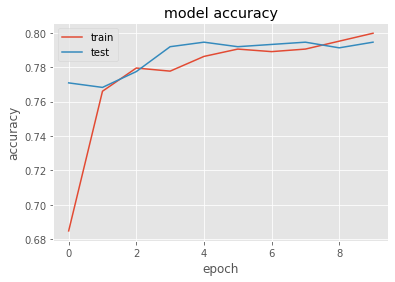

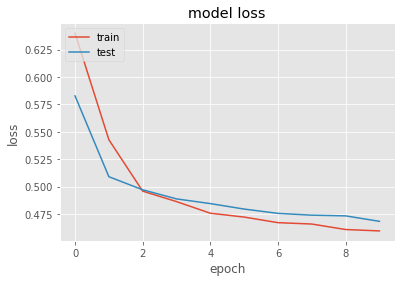

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-05-02 23:01:18--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.33.154
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.33.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  68.3MB/s    in 22s     

2021-05-02 23:01:40 (71.6 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
 word2vec.save_word2vec_format('./GoogleNews-vectors-negative300.txt', binary=False)

In [ ]:
vec_king = word2vec['king']
vec_king.shape

(300,)

In [ ]:
pretrained_embedding_file = "word2vec-google-news-300"

In [ ]:
print('Indexing word vectors.')

embeddings_index_1 = {}
f = open('googleword2vec.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_1[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_1))

Indexing word vectors.
Found 3000000 word vectors.


In [ ]:
len(embeddings_index_1.keys())

3000000

In [ ]:
num_words=len(tokenizer_obj.word_index)+1
embedding_matrix_1=np.zeros((num_words,300)) # it is 100d
for word,i in tqdm(tokenizer_obj.word_index.items()):
    # if i > num_words:
    #     continue
    emb_vec=embeddings_index_1.get(word)
    if emb_vec is not None:
        embedding_matrix_1[i]=emb_vec

100%|██████████| 16125/16125 [00:00<00:00, 192622.84it/s]


In [ ]:
embedding_matrix_1.shape

(16126, 300)

In [ ]:
longest_train = max(df['text'], key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

In [ ]:
length_long_sentence

31

In [ ]:
MAX_LEN = 50

In [ ]:
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
tweet_pad.shape

(7613, 50)

In [ ]:
from keras.layers import Bidirectional

model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(units=64, dropout=0.1,  recurrent_dropout=0.1, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(tweet_pad,df['target'].values,test_size=0.2)


In [ ]:
X_train.shape

(6090, 50)

In [ ]:
history=model.fit(X_train,y_train,batch_size=15,epochs=10,validation_data=(X_test,y_test),verbose=1)

Epoch 1/10
406/406 [==============================] - 50s 107ms/step - loss: 0.6620 - accuracy: 0.6230 - val_loss: 0.5854 - val_accuracy: 0.7420
Epoch 2/10
406/406 [==============================] - 42s 103ms/step - loss: 0.5671 - accuracy: 0.7487 - val_loss: 0.5152 - val_accuracy: 0.7722
Epoch 3/10
406/406 [==============================] - 42s 103ms/step - loss: 0.5073 - accuracy: 0.7749 - val_loss: 0.4977 - val_accuracy: 0.7794
Epoch 4/10
406/406 [==============================] - 41s 102ms/step - loss: 0.4952 - accuracy: 0.7771 - val_loss: 0.4901 - val_accuracy: 0.7820
Epoch 5/10
406/406 [==============================] - 41s 102ms/step - loss: 0.4882 - accuracy: 0.7846 - val_loss: 0.4858 - val_accuracy: 0.7905
Epoch 6/10
406/406 [==============================] - 41s 102ms/step - loss: 0.4876 - accuracy: 0.7759 - val_loss: 0.4793 - val_accuracy: 0.7899
Epoch 7/10
406/406 [==============================] - 41s 102ms/step - loss: 0.4740 - accuracy: 0.7917 - val_loss: 0.4751 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


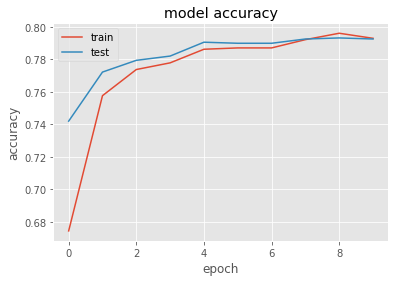

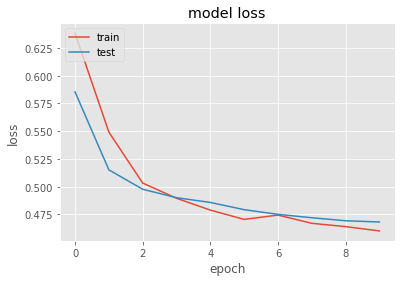

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import re

In [ ]:
!pip install transformers

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_ml.csv to train_ml.csv


In [ ]:
df = pd.read_csv('train_ml.csv')

In [ ]:
df['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [ ]:
# Using google colab text cleaning
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and lemma
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df["text"] = df["text"].apply(clean_text)

In [ ]:
df['text']

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    aria ahrary thetawniest control wild fire cali...
7610             utc km volcano hawaii http co zdtoyd ebj
7611    police investigating bike collided car little ...
7612    latest home razed northern california wildfire...
Name: text, Length: 7613, dtype: object

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [ ]:
tokenized =   df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
tokenized

0       [101, 15046, 3114, 8372, 2089, 16455, 9641, 10...
1       [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...
2       [101, 6319, 2356, 7713, 2173, 19488, 2961, 139...
3       [101, 2111, 4374, 3748, 10273, 13982, 2344, 26...
4       [101, 2288, 2741, 6302, 10090, 7397, 5610, 374...
                              ...                        
7608    [101, 2048, 5016, 11308, 3173, 2958, 7859, 351...
7609    [101, 9342, 6289, 19848, 2100, 23963, 7962, 10...
7610    [101, 11396, 2463, 12779, 7359, 8299, 2522, 10...
7611    [101, 2610, 11538, 7997, 17745, 2482, 2210, 59...
7612    [101, 6745, 2188, 10958, 5422, 2642, 2662, 374...
Name: text, Length: 7613, dtype: object

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)


In [ ]:
max_len

43

In [ ]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
# padded = []
# for i in tokenized.values:
#   x = np.array(i + [0] * (max_len - len(i)))
#   padded.append(x)


In [ ]:
# padded = np.array(padded)

In [ ]:
padded.shape

(7613, 43)

In [ ]:
attention_mask = np.where(padded!= 0, 1, 0)

In [ ]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
model = model_class.from_pretrained(pretrained_weights) # Load pretrained model

In [ ]:
# train_bert.shape

(6090, 84)

In [ ]:
# attention_mask = np.where(train_bert!= 0, 1, 0)

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

In [ ]:
attention_mask.shape

torch.Size([7613, 43])

In [ ]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
labels = df['target']

In [ ]:
labels.shape

(7613,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [ ]:
X_scaled = scaler.transform(X_train)

In [ ]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(max_iter=2000), parameters)
grid_search.fit(X_scaled, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=2000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04...4053e+01, 1.57895579e+01,
       2.10527105e+01, 2.63158632e+01, 3.15790158e+01, 3.68421684e+01,
       4.21053211e+01, 4.73684737e+01, 5.26316263e+01, 5.78947789e+01,
       6.31579316e+01, 6.84210842e+01, 7.36842368e+01, 7.89473895e+01,
       8.42105421e+01, 8.94736947e+01, 9.47368474e+01, 

In [ ]:
grid_search.best_params_

{'C': 0.0001}

In [ ]:
lr_clf = LogisticRegression(C = 0.0001)
lr_clf.fit(X_scaled, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_test)

In [ ]:
X_test_scale = scaler.transform(X_test)

In [ ]:
lr_clf.score(X_test_scale, y_test)

0.7998949579831933

In [ ]:
y_pred = lr_clf.predict(X_test_scale)

In [ ]:
cm = confusion_matrix( y_test, y_pred)  

Confusion matrix, without normalization
[[969 124]
 [257 554]]


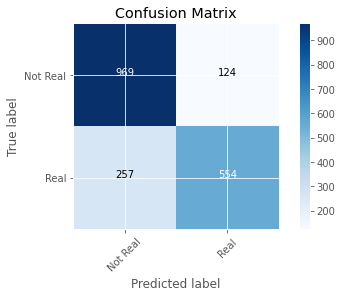

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1093
           1       0.82      0.68      0.74       811

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_ml.csv to test_ml.csv


In [ ]:
df_test = pd.read_csv('test_ml.csv')

In [ ]:
df_test["text"] = df_test["text"].apply(clean_text)

In [ ]:
df_test['text']

0                             happened terrible car crash
1       heard earthquake different city stay safe ever...
2       forest fire spot pond goose fleeing across str...
3                    apocalypse lighting spokane wildfire
4                      typhoon soudelor kill china taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety fasten...
3259    storm ri worse last hurricane city amp others ...
3260     green line derailment chicago http co utbxlcbiuy
3261    meg issue hazardous weather outlook hwo http c...
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [ ]:
tokenized_t = df_test['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized_t.values:
    if len(i) > max_len:
        max_len = len(i)

In [ ]:
padded_t = np.array([i + [0]*(max_len-len(i)) for i in tokenized_t.values])

In [ ]:
padded_t.shape

(3263, 42)

In [ ]:
attention_mask_t = np.where(padded_t != 0, 1, 0)

In [ ]:
input_ids = torch.tensor(padded_t) 

In [ ]:
attention_mask_t = torch.tensor(attention_mask_t)


In [ ]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask_t)

In [ ]:
val_features = last_hidden_states[0][:,0,:].numpy() 

In [ ]:
y_pred = lr_clf.predict(val_features)

In [ ]:
submission = pd.DataFrame()
submission['id'] = df_test['id']
submission['target'] = y_pred
submission.to_csv('submission-bert-2.csv', index=False)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
sample_submission["target"] = y_pred.astype('int64')


In [ ]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,0


In [ ]:
sample_submission.to_csv("submission_v3.csv", index=False)